In [1]:
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## Util

In [2]:
def show_result(num_epoch):
    z_ = np.random.normal(0, 1, (25, 100))
    
    test_images = sess.run(G_z, {z: z_, drop_out: 0.0})
    
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        
    for k in range(25):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')
        
    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    plt.show()

## Model

In [3]:
def generator(x):
    # init
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)
    
    # layer1
    w0 = tf.get_variable('G_w0', [x.get_shape()[1], 256], initializer=w_init)
    b0 = tf.get_variable('G_b0', [256], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)
    
    # layer2
    w1 = tf.get_variable('G_w1', [h0.get_shape()[1], 512], initializer=w_init)
    b1 = tf.get_variable('G_b1', [512], initializer=b_init)
    h1 = tf.nn.relu(tf.matmul(h0, w1) + b1)
    
    # layer3
    w2 = tf.get_variable('G_w2', [h1.get_shape()[1], 1024], initializer=w_init)
    b2 = tf.get_variable('G_b2', [1024], initializer=b_init)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    
    # layer4
    w3 = tf.get_variable('G_w3', [h2.get_shape()[1], 784], initializer=w_init)
    b3 = tf.get_variable('G_b3', [784], initializer=b_init)
    o = tf.nn.tanh(tf.matmul(h2, w3) + b3)
    
    return o

In [4]:
def discriminator(x, drop_out):
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)
    
    # layer1
    w0 = tf.get_variable('D_w0', [x.get_shape()[1], 1024], initializer=w_init)
    b0 = tf.get_variable('D_b0', [1024], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)
    h0 = tf.nn.dropout(h0, drop_out)
    
    # layer2
    w1 = tf.get_variable('D_w1', [h0.get_shape()[1], 512], initializer=w_init)
    b1 = tf.get_variable('D_b1', [512], initializer=b_init)
    h1 = tf.nn.relu(tf.matmul(h0, w1) + b1)
    h1 = tf.nn.dropout(h1, drop_out)
    
    # layer3
    w2 = tf.get_variable('D_w2', [h1.get_shape()[1], 256], initializer=w_init)
    b2 = tf.get_variable('D_b2', [256], initializer=b_init)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    h2 = tf.nn.dropout(h2, drop_out)
    
    # output layer
    w3 = tf.get_variable('D_w3', [h2.get_shape()[1], 1], initializer=w_init)
    b3 = tf.get_variable('D_b3', [1], initializer=b_init)
    o = tf.sigmoid(tf.matmul(h2, w3) + b3)
    
    return o

### Train

In [5]:
batch_size = 100
lr = 0.0002
train_epoch = 100

In [6]:
# load dataset
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
train_set = (mnist.train.images - 0.5) / 0.5

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
# network 
with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=(None, 100))
    G_z = generator(z)

with tf.variable_scope('D') as scope:
    drop_out = tf.placeholder(dtype=tf.float32, name='drop_out')
    x = tf.placeholder(tf.float32, shape=(None, 784))
    D_real = discriminator(x, drop_out)
    scope.reuse_variables()
    D_fake = discriminator(G_z, drop_out)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
# loss
eps = 1e-2
D_loss = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))
G_loss = tf.reduce_mean(-tf.log(D_fake + eps))

In [9]:
# optimizer
t_vars = tf.trainable_variables()
D_vars = [var for var in t_vars if 'D_' in var.name]
G_vars = [var for var in t_vars if 'G_' in var.name]

D_optim = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=D_vars)
G_optim = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_vars)

In [10]:
# session
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [11]:
# train
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

In [12]:
np.random.seed(int(time.time()))

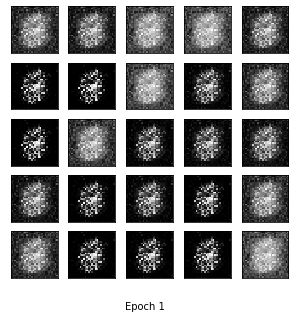

[1/100] - ptime: 26.28 loss_d: 0.656 loss_g: 1.616


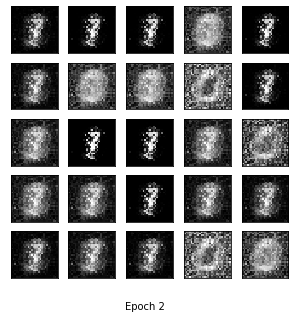

[2/100] - ptime: 27.10 loss_d: 0.314 loss_g: 2.708


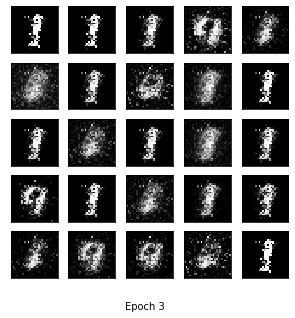

[3/100] - ptime: 26.47 loss_d: 0.426 loss_g: 2.536


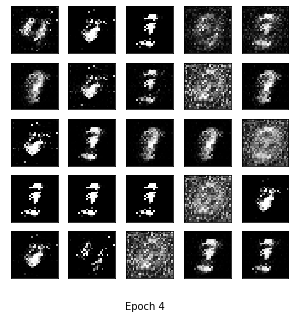

[4/100] - ptime: 25.34 loss_d: 0.538 loss_g: 2.160


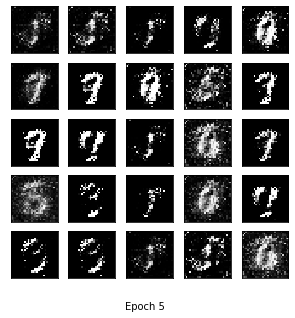

[5/100] - ptime: 24.14 loss_d: 0.702 loss_g: 1.729


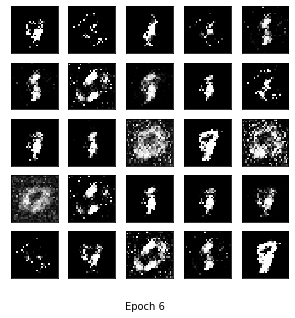

[6/100] - ptime: 25.03 loss_d: 0.662 loss_g: 1.800


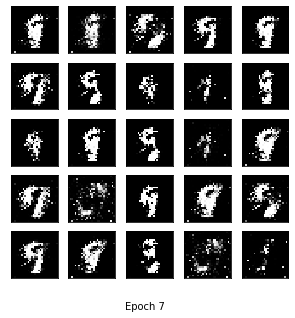

[7/100] - ptime: 25.65 loss_d: 0.655 loss_g: 1.922


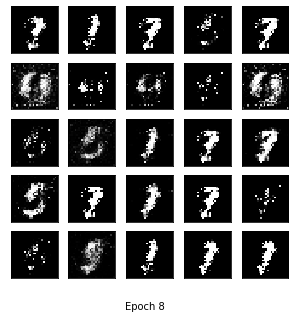

[8/100] - ptime: 25.89 loss_d: 0.638 loss_g: 2.043


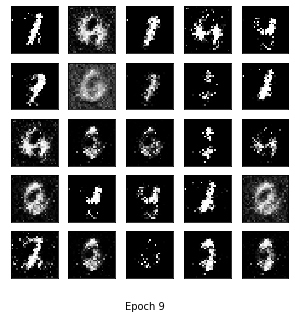

[9/100] - ptime: 23.99 loss_d: 0.765 loss_g: 1.697


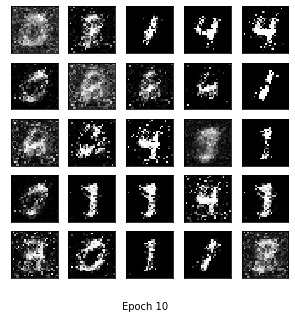

[10/100] - ptime: 23.65 loss_d: 0.906 loss_g: 1.444


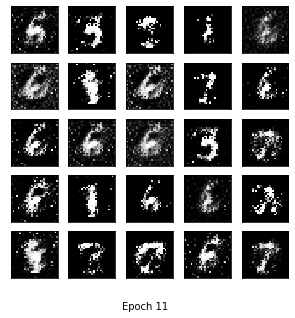

[11/100] - ptime: 23.45 loss_d: 1.026 loss_g: 1.189


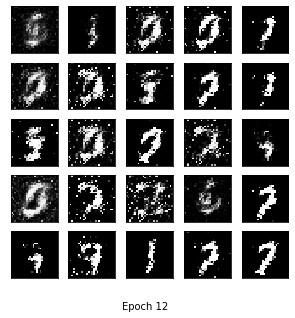

[12/100] - ptime: 23.47 loss_d: 1.011 loss_g: 1.134


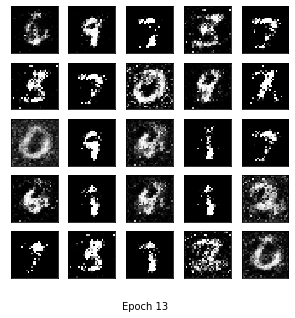

[13/100] - ptime: 24.05 loss_d: 1.031 loss_g: 1.141


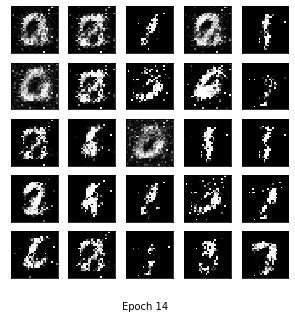

[14/100] - ptime: 24.16 loss_d: 1.044 loss_g: 1.063


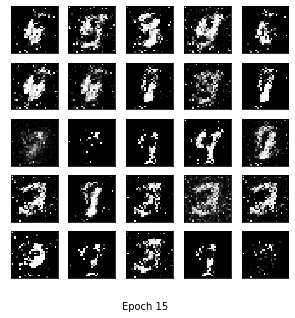

[15/100] - ptime: 24.91 loss_d: 1.023 loss_g: 1.117


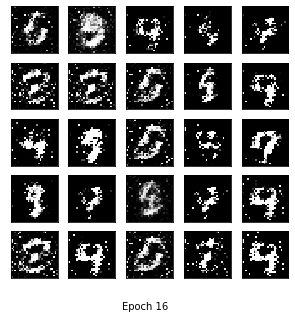

[16/100] - ptime: 24.60 loss_d: 1.027 loss_g: 1.181


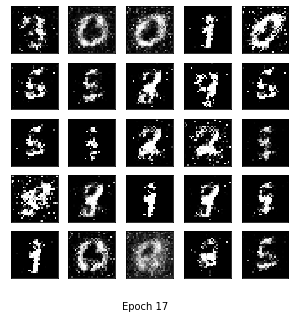

[17/100] - ptime: 23.75 loss_d: 1.068 loss_g: 1.125


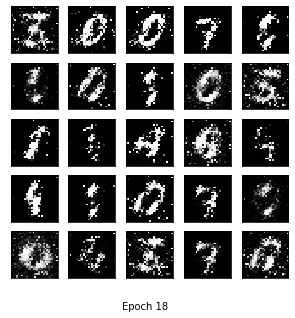

[18/100] - ptime: 23.53 loss_d: 1.055 loss_g: 1.111


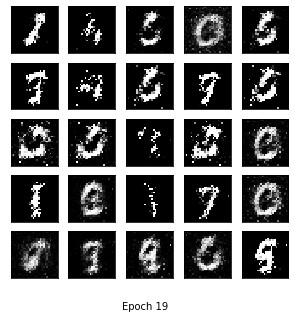

[19/100] - ptime: 23.53 loss_d: 1.065 loss_g: 1.070


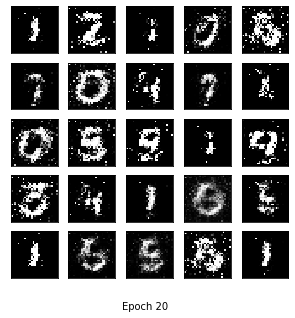

[20/100] - ptime: 23.62 loss_d: 1.090 loss_g: 1.048


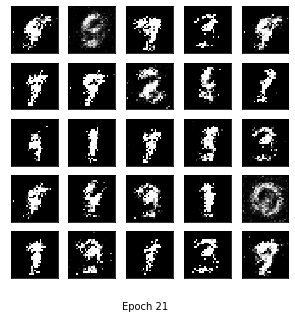

[21/100] - ptime: 23.50 loss_d: 1.185 loss_g: 0.957


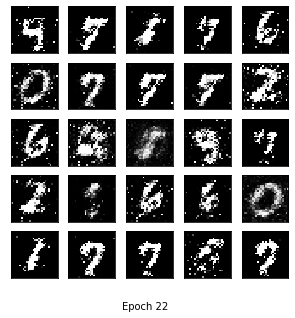

[22/100] - ptime: 23.98 loss_d: 1.117 loss_g: 0.979


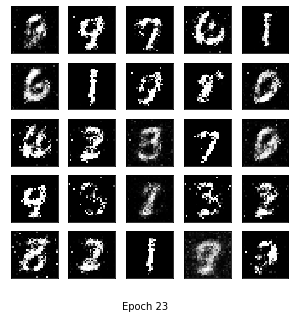

[23/100] - ptime: 23.49 loss_d: 1.130 loss_g: 1.041


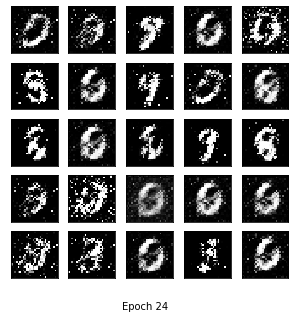

[24/100] - ptime: 23.28 loss_d: 1.184 loss_g: 0.925


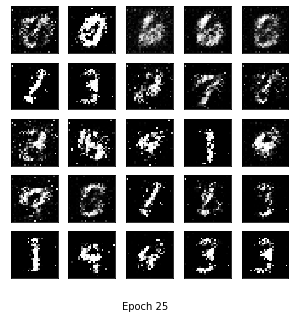

[25/100] - ptime: 23.25 loss_d: 1.217 loss_g: 0.888


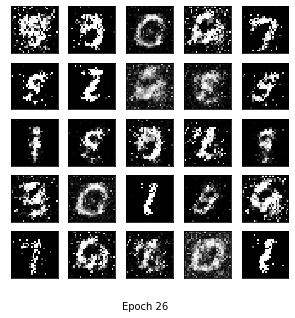

[26/100] - ptime: 23.41 loss_d: 1.227 loss_g: 0.838


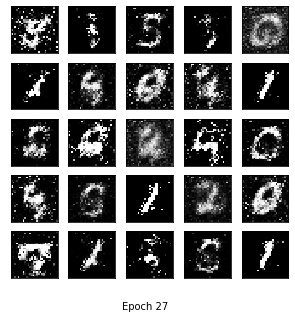

[27/100] - ptime: 23.49 loss_d: 1.225 loss_g: 0.870


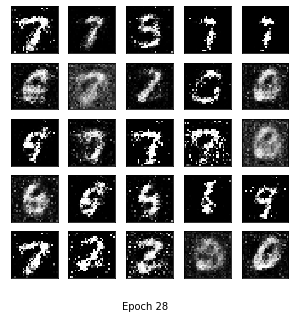

[28/100] - ptime: 23.91 loss_d: 1.271 loss_g: 0.802


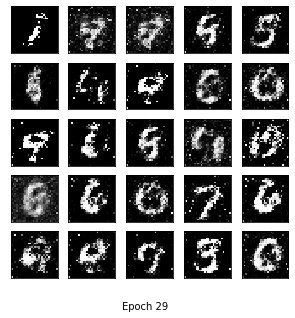

[29/100] - ptime: 23.65 loss_d: 1.268 loss_g: 0.788


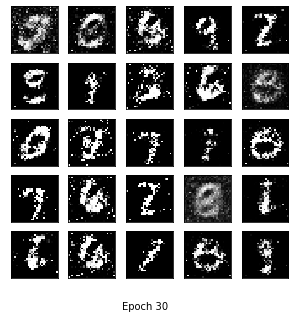

[30/100] - ptime: 23.66 loss_d: 1.256 loss_g: 0.801


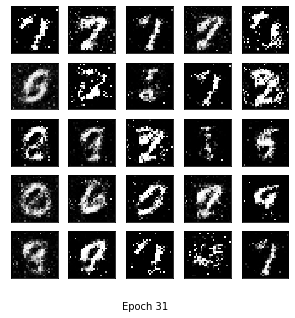

[31/100] - ptime: 23.53 loss_d: 1.251 loss_g: 0.802


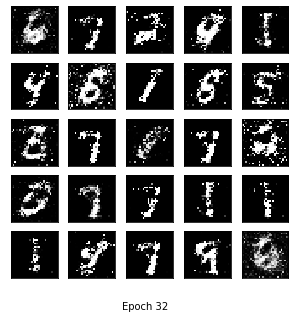

[32/100] - ptime: 23.70 loss_d: 1.268 loss_g: 0.809


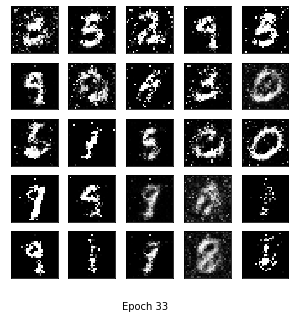

[33/100] - ptime: 23.61 loss_d: 1.240 loss_g: 0.849


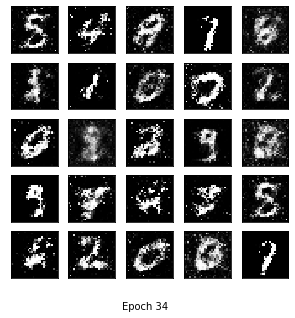

[34/100] - ptime: 23.51 loss_d: 1.269 loss_g: 0.788


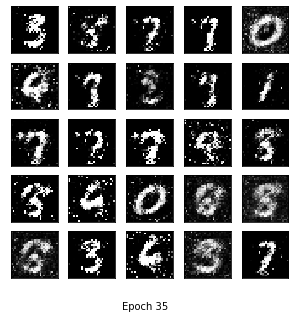

[35/100] - ptime: 23.42 loss_d: 1.296 loss_g: 0.744


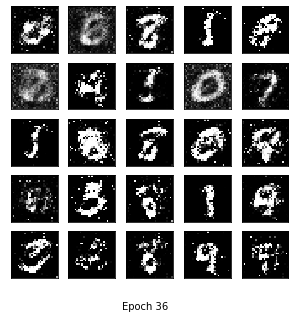

[36/100] - ptime: 23.41 loss_d: 1.251 loss_g: 0.783


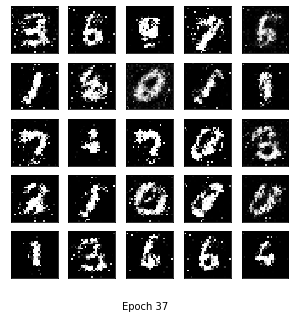

[37/100] - ptime: 23.66 loss_d: 1.283 loss_g: 0.783


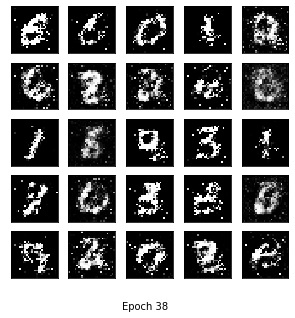

[38/100] - ptime: 23.41 loss_d: 1.268 loss_g: 0.781


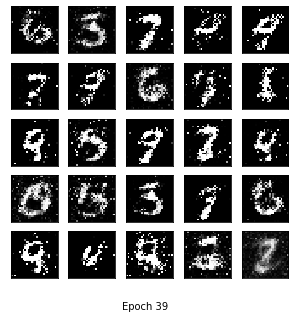

[39/100] - ptime: 23.49 loss_d: 1.273 loss_g: 0.784


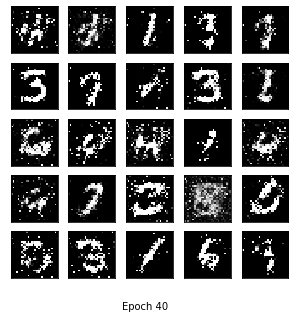

[40/100] - ptime: 24.13 loss_d: 1.282 loss_g: 0.788


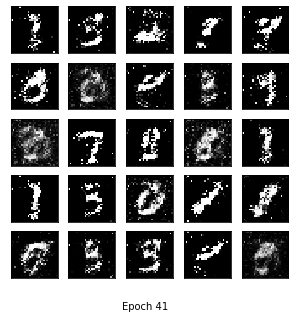

[41/100] - ptime: 23.57 loss_d: 1.264 loss_g: 0.788


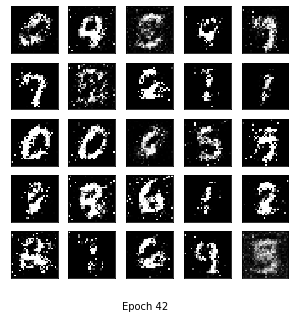

[42/100] - ptime: 23.73 loss_d: 1.266 loss_g: 0.818


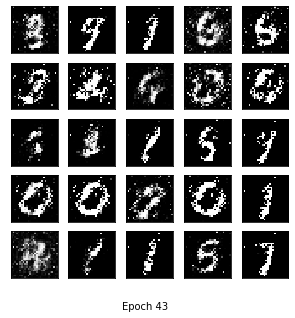

[43/100] - ptime: 23.57 loss_d: 1.255 loss_g: 0.773


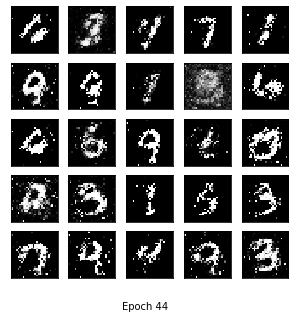

[44/100] - ptime: 23.56 loss_d: 1.285 loss_g: 0.800


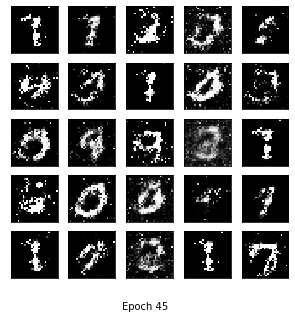

[45/100] - ptime: 23.51 loss_d: 1.298 loss_g: 0.750


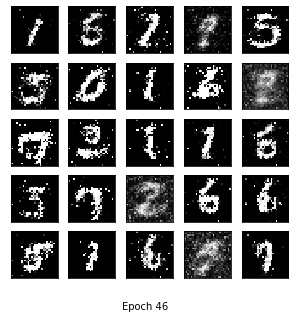

[46/100] - ptime: 23.60 loss_d: 1.316 loss_g: 0.730


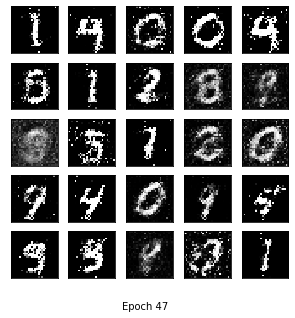

[47/100] - ptime: 23.76 loss_d: 1.315 loss_g: 0.719


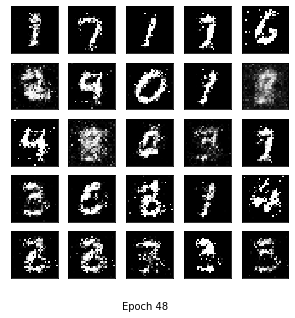

[48/100] - ptime: 2353.01 loss_d: 1.302 loss_g: 0.757


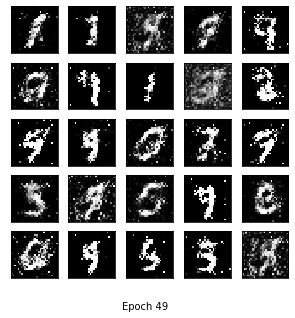

[49/100] - ptime: 90.04 loss_d: 1.310 loss_g: 0.727


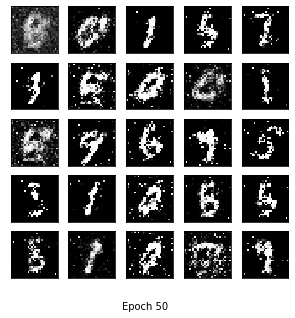

[50/100] - ptime: 89.27 loss_d: 1.315 loss_g: 0.732


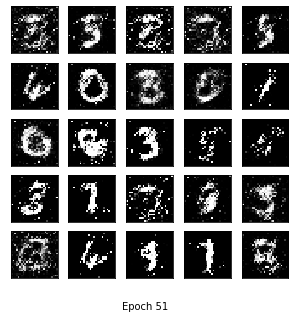

[51/100] - ptime: 88.13 loss_d: 1.305 loss_g: 0.733


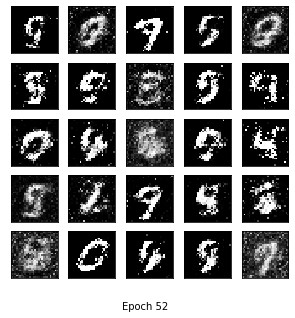

[52/100] - ptime: 89.90 loss_d: 1.323 loss_g: 0.740


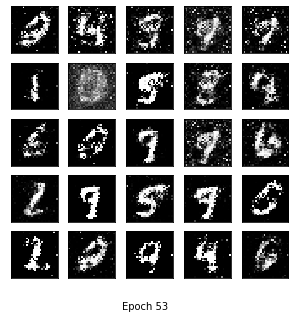

[53/100] - ptime: 89.39 loss_d: 1.323 loss_g: 0.703


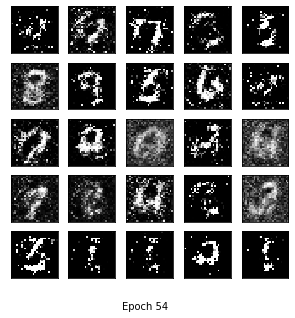

[54/100] - ptime: 88.66 loss_d: 1.314 loss_g: 0.721


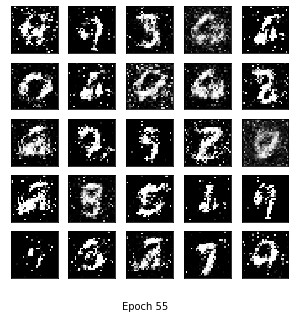

[55/100] - ptime: 88.86 loss_d: 1.323 loss_g: 0.728


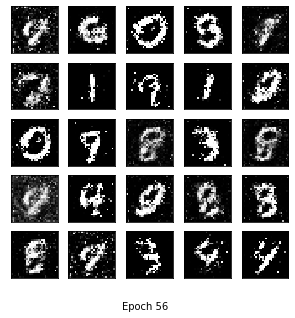

[56/100] - ptime: 88.88 loss_d: 1.323 loss_g: 0.721


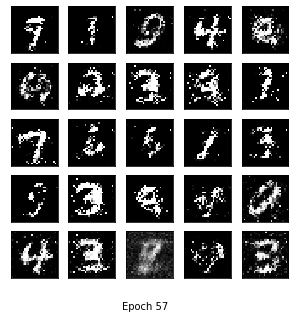

[57/100] - ptime: 939.05 loss_d: 1.325 loss_g: 0.701


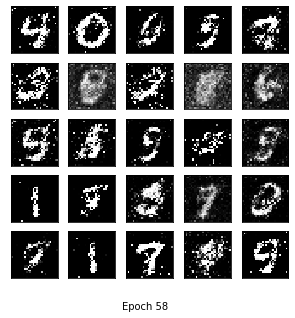

[58/100] - ptime: 100.16 loss_d: 1.332 loss_g: 0.706


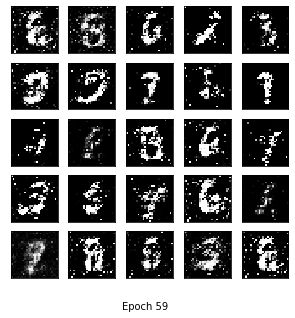

[59/100] - ptime: 27.63 loss_d: 1.308 loss_g: 0.728


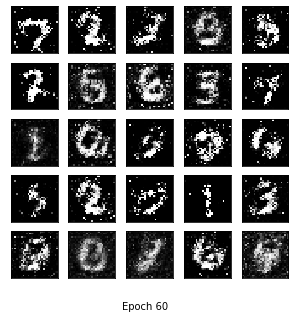

[60/100] - ptime: 27.72 loss_d: 1.326 loss_g: 0.723


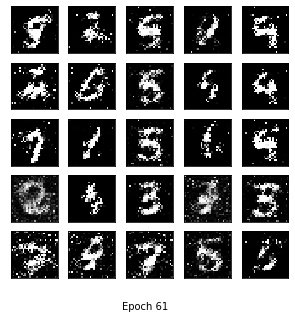

[61/100] - ptime: 24.73 loss_d: 1.327 loss_g: 0.713


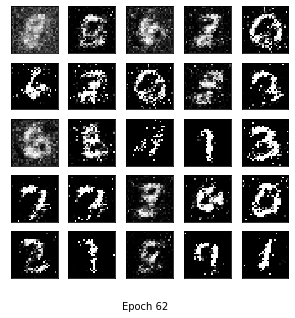

[62/100] - ptime: 25.96 loss_d: 1.331 loss_g: 0.695


In [ ]:
start_time = time.time()

for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    
    epoch_start_time = time.time()
    for iter in range(train_set.shape[0] // batch_size):
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 100))
        
        _, loss_d_ = sess.run([D_optim, D_loss], {x: x_, z: z_, drop_out: 0.3})
        D_losses.append(loss_d_)
        
        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 100))
        _, loss_g_ = sess.run([G_optim, G_loss], {z: z_, drop_out: 0.3})
        G_losses.append(loss_g_)
    epoch_end_time = time.time()
    
    show_result((epoch + 1))
    
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
    
end_time = time.time()

total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)